In [ ]:
pip install optuna

     |████████████████████████████████| 308 kB 3.2 MB/s 
     |████████████████████████████████| 210 kB 51.2 MB/s 
     |████████████████████████████████| 81 kB 8.4 MB/s 
     |████████████████████████████████| 78 kB 4.5 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 150 kB 43.4 MB/s 
     |████████████████████████████████| 113 kB 64.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=02aa5eb129aeb1c19209c8e15346759a12a95bafc84b1460c581254c06e3c855
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
# Basic Library
import pandas as pd
import numpy as np
import os

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
train_x = train.iloc[:, 1:-1]
test_x = test.iloc[:, 1:]

train_x = np.array(train_x).reshape(-1, 8, 4, 1)
test_x = np.array(test_x).reshape(-1, 8, 4, 1)

ohe = OneHotEncoder(sparse = False)
train_y = ohe.fit_transform(train[['target']])

In [ ]:
def create_model(num_layer, mid_units, num_filters):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters[0], kernel_size=(2, 2),
                 activation="elu",
                 input_shape=(8, 4, 1)))
    model.add(BatchNormalization())

    for i in range(1,num_layer):
        model.add(Conv2D(filters=num_filters[i], kernel_size=(2, 2), padding="same", activation="elu"))
        model.add(BatchNormalization())

            
    model.add(GlobalAveragePooling2D())
    model.add(Dense(mid_units, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [ ]:
def cnn_objective(trial: Trial) -> float:
    
    #clear_session
    keras.backend.clear_session()
    
    #number of the convolution layer
    num_layer = trial.suggest_int("num_layer", 2, 3)
    
    #number of the unit
    mid_units = int(trial.suggest_discrete_uniform("mid_units", 30, 150, 10))
    
    #number of the each convolution layer filter
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]

    #Dropout
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    dropout_rate = [int(trial.suggest_uniform("dropout_rate"+str(ii), 0.0, 0.5)) for ii in range(num_layer+1)]
    
        
    seed = 42
    kfold = StratifiedKFold(n_splits=5, random_state = seed, shuffle = True) # Cross-validation cv=5
    es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)
    cv = np.zeros((train_x.shape[0], 4))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train.target)):

        x_train, y_train = train_x[train_idx], train_y[train_idx]
        x_val, y_val = train_x[val_idx], train_y[val_idx]
        
        mc = ModelCheckpoint(f"model_{n+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
        
        model = create_model(num_layer, mid_units, num_filters)
        
        # Adam optimizer learning rate
        optimizer = Adam(learning_rate=trial.suggest_uniform("learning_rate", 0.0005, 0.005))
        model.compile(optimizer=optimizer,
                      loss="categorical_crossentropy",
                      metrics=["acc"])
        model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, 
                  callbacks=[es,mc], verbose=None)
        
        best = load_model(f"model_{n+1}.h5")
        
        cv[val_idx, :] = best.predict(x_val)
        
    print('multi_logloss:', log_loss(train_y, cv))
    print('accuracy_score:', accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1)))

    
    return accuracy_score(np.argmax(train_y, axis=1), np.argmax(cv, axis=1))

In [ ]:
sampler = TPESampler(seed=42)
cnn_study = optuna.create_study(study_name="cnn_parameter_opt", direction="maximize", sampler=sampler)
cnn_study.optimize(cnn_objective, n_trials=20)

[I 2022-03-15 16:35:31,317] A new study created in memory with name: cnn_parameter_opt
[I 2022-03-15 16:38:09,290] Trial 0 finished with value: 0.867237687366167 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 192.0, 'num_filter_1': 160.0, 'dropout_rate': 0.07800932022121826, 'dropout_rate0': 0.07799726016810132, 'dropout_rate1': 0.02904180608409973, 'dropout_rate2': 0.4330880728874676, 'learning_rate': 0.00320501755284444}. Best is trial 0 with value: 0.867237687366167.


multi_logloss: 0.38342003817367176
accuracy_score: 0.867237687366167


[I 2022-03-15 16:42:59,047] Trial 1 finished with value: 0.8728051391862955 and parameters: {'num_layer': 3, 'mid_units': 30.0, 'num_filter_0': 256.0, 'num_filter_1': 224.0, 'num_filter_2': 64.0, 'dropout_rate': 0.09091248360355031, 'dropout_rate0': 0.09170225492671691, 'dropout_rate1': 0.15212112147976886, 'dropout_rate2': 0.2623782158161189, 'dropout_rate3': 0.21597250932105788, 'learning_rate': 0.0018105311308911887}. Best is trial 1 with value: 0.8728051391862955.


multi_logloss: 0.37823853934889207
accuracy_score: 0.8728051391862955


[I 2022-03-15 16:44:32,774] Trial 2 finished with value: 0.8740899357601714 and parameters: {'num_layer': 3, 'mid_units': 40.0, 'num_filter_0': 80.0, 'num_filter_1': 96.0, 'num_filter_2': 128.0, 'dropout_rate': 0.3925879806965068, 'dropout_rate0': 0.09983689107917987, 'dropout_rate1': 0.2571172192068058, 'dropout_rate2': 0.29620728443102123, 'dropout_rate3': 0.023225206359998862, 'learning_rate': 0.003233951833556473}. Best is trial 2 with value: 0.8740899357601714.


multi_logloss: 0.41362400646119557
accuracy_score: 0.8740899357601714


[I 2022-03-15 16:47:50,265] Trial 3 finished with value: 0.867237687366167 and parameters: {'num_layer': 2, 'mid_units': 30.0, 'num_filter_0': 256.0, 'num_filter_1': 256.0, 'dropout_rate': 0.40419867405823057, 'dropout_rate0': 0.15230688458668534, 'dropout_rate1': 0.048836057003191935, 'dropout_rate2': 0.34211651325607845, 'learning_rate': 0.002480686221828206}. Best is trial 2 with value: 0.8740899357601714.


multi_logloss: 0.3883901069040703
accuracy_score: 0.867237687366167


[I 2022-03-15 16:48:51,391] Trial 4 finished with value: 0.8638115631691649 and parameters: {'num_layer': 2, 'mid_units': 90.0, 'num_filter_0': 16.0, 'num_filter_1': 240.0, 'dropout_rate': 0.12938999080000846, 'dropout_rate0': 0.331261142176991, 'dropout_rate1': 0.15585553804470548, 'dropout_rate2': 0.2600340105889054, 'learning_rate': 0.0029601962570447587}. Best is trial 2 with value: 0.8740899357601714.


multi_logloss: 0.4067048817058152
accuracy_score: 0.8638115631691649


[I 2022-03-15 16:54:24,855] Trial 5 finished with value: 0.8736616702355461 and parameters: {'num_layer': 2, 'mid_units': 150.0, 'num_filter_0': 208.0, 'num_filter_1': 256.0, 'dropout_rate': 0.4474136752138244, 'dropout_rate0': 0.29894998940554257, 'dropout_rate1': 0.4609371175115584, 'dropout_rate2': 0.04424625102595975, 'learning_rate': 0.0013819228808861534}. Best is trial 2 with value: 0.8740899357601714.


multi_logloss: 0.3670306743317489
accuracy_score: 0.8736616702355461


[I 2022-03-15 16:55:32,268] Trial 6 finished with value: 0.8680942184154176 and parameters: {'num_layer': 2, 'mid_units': 70.0, 'num_filter_0': 112.0, 'num_filter_1': 80.0, 'dropout_rate': 0.41436875457596467, 'dropout_rate0': 0.17837666334679464, 'dropout_rate1': 0.14046725484369038, 'dropout_rate2': 0.27134804157912423, 'learning_rate': 0.001134159012386432}. Best is trial 2 with value: 0.8740899357601714.


multi_logloss: 0.39191375483043994
accuracy_score: 0.8680942184154176


[I 2022-03-15 17:00:27,994] Trial 7 finished with value: 0.8676659528907923 and parameters: {'num_layer': 3, 'mid_units': 30.0, 'num_filter_0': 256.0, 'num_filter_1': 208.0, 'num_filter_2': 64.0, 'dropout_rate': 0.0027610585618011996, 'dropout_rate0': 0.4077307142274171, 'dropout_rate1': 0.35342867192380856, 'dropout_rate2': 0.36450358402049365, 'dropout_rate3': 0.38563517334297287, 'learning_rate': 0.0008332009328034067}. Best is trial 2 with value: 0.8740899357601714.


multi_logloss: 0.37947543078618307
accuracy_score: 0.8676659528907923


[I 2022-03-15 17:02:55,821] Trial 8 finished with value: 0.8668094218415417 and parameters: {'num_layer': 2, 'mid_units': 40.0, 'num_filter_0': 224.0, 'num_filter_1': 160.0, 'dropout_rate': 0.1654490124263246, 'dropout_rate0': 0.03177917514301182, 'dropout_rate1': 0.1554911608578311, 'dropout_rate2': 0.16259166101337352, 'learning_rate': 0.0037832278025212887}. Best is trial 2 with value: 0.8740899357601714.


multi_logloss: 0.3922280739463057
accuracy_score: 0.8668094218415417


[I 2022-03-15 17:04:12,131] Trial 9 finished with value: 0.8698072805139186 and parameters: {'num_layer': 3, 'mid_units': 140.0, 'num_filter_0': 128.0, 'num_filter_1': 32.0, 'num_filter_2': 192.0, 'dropout_rate': 0.3803925243084487, 'dropout_rate0': 0.2806385987847481, 'dropout_rate1': 0.3854835899772805, 'dropout_rate2': 0.24689779818219537, 'dropout_rate3': 0.26136641469099703, 'learning_rate': 0.0024239345826134735}. Best is trial 2 with value: 0.8740899357601714.


multi_logloss: 0.3955235021940127
accuracy_score: 0.8698072805139186


[I 2022-03-15 17:06:25,050] Trial 10 finished with value: 0.8612419700214132 and parameters: {'num_layer': 3, 'mid_units': 60.0, 'num_filter_0': 48.0, 'num_filter_1': 96.0, 'num_filter_2': 256.0, 'dropout_rate': 0.28760403340763635, 'dropout_rate0': 0.47988537297271006, 'dropout_rate1': 0.2713272127278322, 'dropout_rate2': 0.47348093819507464, 'dropout_rate3': 0.006155584782468915, 'learning_rate': 0.004921462601717418}. Best is trial 2 with value: 0.8740899357601714.


multi_logloss: 0.44495396745745663
accuracy_score: 0.8612419700214132


[I 2022-03-15 17:08:06,705] Trial 11 finished with value: 0.867237687366167 and parameters: {'num_layer': 3, 'mid_units': 110.0, 'num_filter_0': 80.0, 'num_filter_1': 112.0, 'num_filter_2': 144.0, 'dropout_rate': 0.49657977296019684, 'dropout_rate0': 0.18791858137226364, 'dropout_rate1': 0.4698875930152806, 'dropout_rate2': 0.003312717201662062, 'dropout_rate3': 0.04073548284008621, 'learning_rate': 0.004058761091995755}. Best is trial 2 with value: 0.8740899357601714.


multi_logloss: 0.4253668439270762
accuracy_score: 0.867237687366167


[I 2022-03-15 17:09:06,953] Trial 12 finished with value: 0.8685224839400428 and parameters: {'num_layer': 2, 'mid_units': 120.0, 'num_filter_0': 176.0, 'num_filter_1': 48.0, 'dropout_rate': 0.2985512417317285, 'dropout_rate0': 0.2908035713097702, 'dropout_rate1': 0.4916334914420415, 'dropout_rate2': 0.059876584754694, 'learning_rate': 0.0015856803170538635}. Best is trial 2 with value: 0.8740899357601714.


multi_logloss: 0.37550396534867725
accuracy_score: 0.8685224839400428


[I 2022-03-15 17:13:27,579] Trial 13 finished with value: 0.8745182012847966 and parameters: {'num_layer': 3, 'mid_units': 90.0, 'num_filter_0': 176.0, 'num_filter_1': 192.0, 'num_filter_2': 128.0, 'dropout_rate': 0.4913603785333849, 'dropout_rate0': 0.36449201918354784, 'dropout_rate1': 0.27171219056756063, 'dropout_rate2': 0.11729867116189362, 'dropout_rate3': 0.16203099504837734, 'learning_rate': 0.001987795919279801}. Best is trial 13 with value: 0.8745182012847966.


multi_logloss: 0.39514051977223036
accuracy_score: 0.8745182012847966


[I 2022-03-15 17:15:45,084] Trial 14 finished with value: 0.8663811563169165 and parameters: {'num_layer': 3, 'mid_units': 70.0, 'num_filter_0': 160.0, 'num_filter_1': 176.0, 'num_filter_2': 128.0, 'dropout_rate': 0.34170324047699696, 'dropout_rate0': 0.3912625156378111, 'dropout_rate1': 0.24788031645382952, 'dropout_rate2': 0.13345187603777642, 'dropout_rate3': 0.14746799031449576, 'learning_rate': 0.003585815074364052}. Best is trial 13 with value: 0.8745182012847966.


multi_logloss: 0.42539593752983357
accuracy_score: 0.8663811563169165


[I 2022-03-15 17:17:22,215] Trial 15 finished with value: 0.8710920770877945 and parameters: {'num_layer': 3, 'mid_units': 90.0, 'num_filter_0': 80.0, 'num_filter_1': 128.0, 'num_filter_2': 128.0, 'dropout_rate': 0.4746084370909637, 'dropout_rate0': 0.37549861800626305, 'dropout_rate1': 0.26288418784884104, 'dropout_rate2': 0.1707750474677462, 'dropout_rate3': 0.11672863720509496, 'learning_rate': 0.00207057240460319}. Best is trial 13 with value: 0.8745182012847966.


multi_logloss: 0.3890258517159415
accuracy_score: 0.8710920770877945


[I 2022-03-15 17:20:04,087] Trial 16 finished with value: 0.8629550321199143 and parameters: {'num_layer': 3, 'mid_units': 50.0, 'num_filter_0': 96.0, 'num_filter_1': 192.0, 'num_filter_2': 176.0, 'dropout_rate': 0.2533881284358335, 'dropout_rate0': 0.4981535345701359, 'dropout_rate1': 0.3329024040995968, 'dropout_rate2': 0.10958900917836645, 'dropout_rate3': 0.2924094610906549, 'learning_rate': 0.003117975526648793}. Best is trial 13 with value: 0.8745182012847966.


multi_logloss: 0.40088656146247204
accuracy_score: 0.8629550321199143


[I 2022-03-15 17:21:47,046] Trial 17 finished with value: 0.8616702355460385 and parameters: {'num_layer': 3, 'mid_units': 110.0, 'num_filter_0': 144.0, 'num_filter_1': 80.0, 'num_filter_2': 96.0, 'dropout_rate': 0.19964732415940314, 'dropout_rate0': 0.20792899793942163, 'dropout_rate1': 0.2145139506750299, 'dropout_rate2': 0.20048311882612474, 'dropout_rate3': 0.4956385980718, 'learning_rate': 0.004393184721957363}. Best is trial 13 with value: 0.8745182012847966.


multi_logloss: 0.43408409749057514
accuracy_score: 0.8616702355460385


[I 2022-03-15 17:23:24,652] Trial 18 finished with value: 0.8753747323340471 and parameters: {'num_layer': 3, 'mid_units': 70.0, 'num_filter_0': 48.0, 'num_filter_1': 144.0, 'num_filter_2': 32.0, 'dropout_rate': 0.32583557757713705, 'dropout_rate0': 0.23872231069345606, 'dropout_rate1': 0.3166075758316285, 'dropout_rate2': 0.33830902526631385, 'dropout_rate3': 0.10377828026204407, 'learning_rate': 0.0021369668796081083}. Best is trial 18 with value: 0.8753747323340471.


multi_logloss: 0.3654730191552402
accuracy_score: 0.8753747323340471


[I 2022-03-15 17:24:55,354] Trial 19 finished with value: 0.8702355460385439 and parameters: {'num_layer': 3, 'mid_units': 90.0, 'num_filter_0': 16.0, 'num_filter_1': 144.0, 'num_filter_2': 16.0, 'dropout_rate': 0.3392282642821162, 'dropout_rate0': 0.23281265800003345, 'dropout_rate1': 0.3196302451826563, 'dropout_rate2': 0.3929614254344278, 'dropout_rate3': 0.13233021642421713, 'learning_rate': 0.0006436385337258109}. Best is trial 18 with value: 0.8753747323340471.


multi_logloss: 0.39271916411200236
accuracy_score: 0.8702355460385439


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


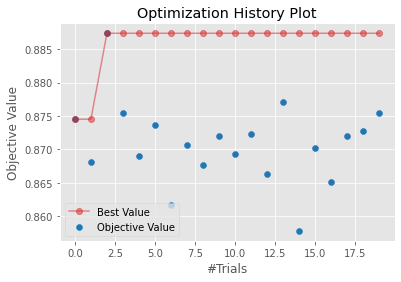

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(cnn_study);

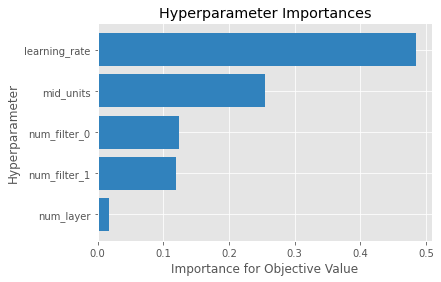

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(cnn_study);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


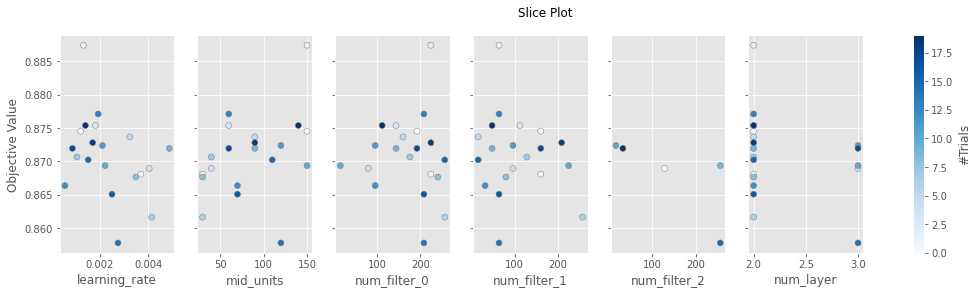

In [ ]:
optuna.visualization.matplotlib.plot_slice(cnn_study);

In [ ]:
cnn_acc = []
cnn_pred = np.zeros((test_x.shape[0], 4))
seed = 42
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
es = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=0)

for i, (train_idx, val_idx) in enumerate(skf.split(train_x, train.target)):
    print(f"{i+1} Fold Training.....")
    x_train, y_train = train_x[train_idx], train_y[train_idx]
    x_val, y_val = train_x[val_idx], train_y[val_idx]
    
    cnn = create_model(cnn_study.best_params['num_layer'], cnn_study.best_params['mid_units'], 
                      [cnn_study.best_params[f'num_filter_{i}'] for i in range(cnn_study.best_params['num_layer'])])
    
    # ModelCheckpoint Fold마다 갱신
    mc = ModelCheckpoint(f"model_{i+1}.h5", save_best_only=True, monitor="val_acc", mode="max", verbose=0)
    
    # 모델 Complie
    optimizer = Adam(learning_rate=cnn_study.best_params['learning_rate'])
    cnn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"])
    cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[es,mc], verbose=0)
    
    # 최고 성능 기록 모델
    best = load_model(f"model_{i+1}.h5")
    
    val_pred = best.predict(x_val)
    
    val_cls = np.argmax(val_pred, axis=1)
    
    fold_cnn_acc = accuracy_score(np.argmax(y_val, axis=1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f"{i+1} Fold ACC of CNN = {fold_cnn_acc}\n")
    
    fold_pred = best.predict(test_x) / skf.n_splits
    cnn_pred += fold_pred

1 Fold Training.....
1 Fold ACC of CNN = 0.8586723768736617

2 Fold Training.....
2 Fold ACC of CNN = 0.8907922912205567

3 Fold Training.....
3 Fold ACC of CNN = 0.8629550321199143

4 Fold Training.....
4 Fold ACC of CNN = 0.8650963597430407

5 Fold Training.....
5 Fold ACC of CNN = 0.8779443254817987



In [ ]:
np.mean(cnn_acc)

0.8710920770877945

In [ ]:
submission['target'] = np.argmax(cnn_pred, axis = 1)
submission.to_csv('submission.csv', index = False)
submission.target.value_counts()

2    2402
3    2380
0    2302
1    2259
Name: target, dtype: int64